In [29]:
%cd /grand/EVITA/ben/cocochorales/cocochorales_full/main_dataset/train/string_track025443/stems_audio
%ls

/lus/grand/projects/EVITA/ben/cocochorales/cocochorales_full/main_dataset/train/string_track025443/stems_audio
1_violin.wav  2_violin.wav  3_viola.wav  4_cello.wav


In [30]:
from IPython.display import Audio

def play_audio(file_path):
    return Audio(file_path)

play_audio('4_cello.wav')  # Replace with your audio file path




In [31]:
import mido

In [32]:
%cd /grand/EVITA/ben/cocochorales/cocochorales_full/main_dataset/train/string_track025443/stems_midi

/lus/grand/projects/EVITA/ben/cocochorales/cocochorales_full/main_dataset/train/string_track025443/stems_midi


In [33]:
mid = mido.MidiFile('4_cello.mid')

In [34]:
from miditoolkit import MidiFile

path_midi = '4_cello.mid'
midi_obj = MidiFile(path_midi)

print(midi_obj)

ticks per beat: 220
max tick: 7036
tempo changes: 1
time sig: 1
key sig: 0
markers: 0
lyrics: False
instruments: 1


In [35]:
midi_obj.instruments[0].notes[0]

Note(velocity=64, pitch=62, start=0, end=220)

In [36]:
import numpy as np
from IPython.display import Audio

def midi_to_freq(midi_pitch):
    return 440 * (2 ** ((midi_pitch - 69) / 12))

def generate_sine_wave(frequency, duration=1.0, sample_rate=44100):
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    sine_wave = np.sin(2 * np.pi * frequency * t)
    return sine_wave

# MIDI pitch 62 is D4
midi_pitch = 62
frequency = midi_to_freq(midi_pitch)

# Generate the sine wave
sine_wave = generate_sine_wave(frequency)

# Use IPython.display.Audio to play the audio
Audio(sine_wave, rate=44100)


In [37]:
# We can get seconds position of the entire piece by using the get_tick_to_time_mapping() 
time_mapping = midi_obj.get_tick_to_time_mapping()[0:10]

In [38]:
print(time_mapping)

[0.         0.00378788 0.00757575 0.01136363 0.01515151 0.01893939
 0.02272726 0.02651514 0.03030302 0.0340909 ]


In [39]:
midi_obj.instruments[0].notes[0]

Note(velocity=64, pitch=62, start=0, end=220)

In [40]:
from miditoolkit.midi import parser as mid_parser
from miditoolkit.pianoroll import parser as pr_parser
from miditoolkit.pianoroll import utils

In [41]:
# load midi file
path_midi = '1_violin.mid'
mido_obj = MidiFile(path_midi)
notes = mido_obj.instruments[0].notes

# convert notes to pianoroll
pianoroll = pr_parser.notes2pianoroll(
                    notes,pitch_range=(0, 108), resample_factor=1/22)

# pianoroll: tick x pitch
print(pianoroll.shape)

(320, 109)


In [42]:
import matplotlib.pyplot as plt

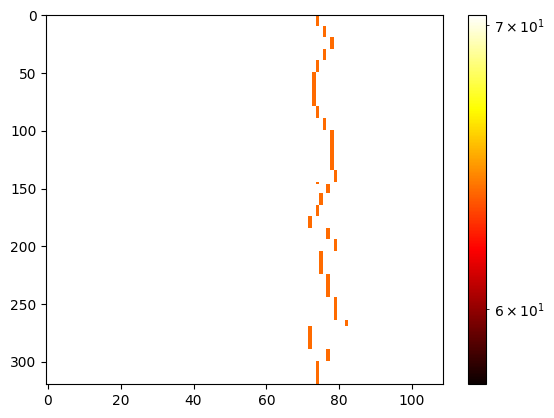

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Assuming pianoroll_small is your 2D numpy array
plt.imshow(pianoroll[0:7041, :], cmap='hot', interpolation='nearest', aspect='auto', norm=colors.LogNorm())
plt.colorbar()
plt.show()

In [44]:
# convert to chromagram (basically summing all octaves)
# chormagram = utils.tochroma(pianoroll)
# print(chormagram.shape)

In [45]:
# resampling
old_resol = mido_obj.ticks_per_beat
new_resol = 24
factor_down = new_resol/ old_resol
print('resampling factor:', factor_down)

# downsample
pianoroll_compressed = pr_parser.notes2pianoroll(
                    notes, 
                    resample_factor=factor_down)
print('downsample:', pianoroll_compressed)

# upsample
notes_re = pr_parser.pianoroll2notes(
                    pianoroll_compressed,
                    resample_factor=1/factor_down)
# check
for pair in zip(notes_re[:5],  notes[:5]):
    print('{} | {}'.format(pair[0], pair[1]))

resampling factor: 0.10909090909090909
downsample: [[ 0  0 64 ...  0  0  0]
 [ 0  0 64 ...  0  0  0]
 [ 0  0 64 ...  0  0  0]
 ...
 [ 0  0 64 ...  0  0  0]
 [ 0  0 64 ...  0  0  0]
 [ 0  0 64 ...  0  0  0]]
Note(velocity=64, pitch=2, start=0, end=220) | Note(velocity=64, pitch=74, start=3, end=223)
Note(velocity=64, pitch=4, start=229, end=430) | Note(velocity=64, pitch=76, start=225, end=434)
Note(velocity=64, pitch=6, start=430, end=650) | Note(velocity=64, pitch=78, start=434, end=653)
Note(velocity=64, pitch=4, start=650, end=870) | Note(velocity=64, pitch=76, start=653, end=873)
Note(velocity=64, pitch=2, start=880, end=1100) | Note(velocity=64, pitch=74, start=878, end=1098)


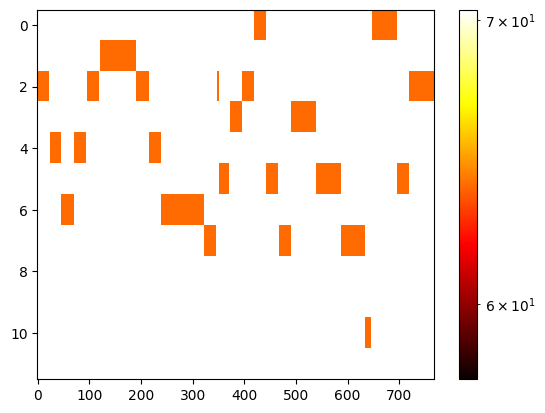

In [46]:
pianoroll
plt.imshow(pianoroll_compressed[:, :].transpose(), cmap='hot', interpolation='nearest', aspect='auto', norm=colors.LogNorm())
plt.colorbar()
plt.show()

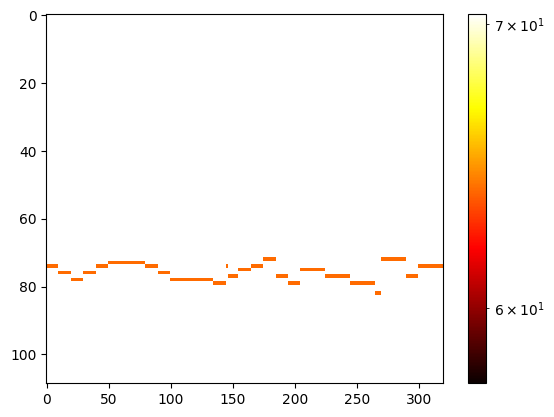

In [47]:
pianoroll
plt.imshow(pianoroll[:, :].transpose(), cmap='hot', interpolation='nearest', aspect='auto', norm=colors.LogNorm())
plt.colorbar()
plt.show()

In [48]:
import torch

In [49]:
import pretty_midi

In [50]:
def midi2piano_roll(filename, filename2=None, target_length = 512, mix_lambda=-1):
    # Initialize pianoroll
    pianoroll = torch.zeros([512, 128]) + 0.01

    # Load MIDI file
    try:
        pm = pretty_midi.PrettyMIDI(filename)
        pianoroll = pm.get_piano_roll(fs=51.2)
        pianoroll = pianoroll.T
        pianoroll = torch.from_numpy(pianoroll).float()
    except Exception as e:  # It's better to catch specific exceptions
        print(f"there is a loading error: {e}")

    target_length = target_length
    n_frames = pianoroll.shape[0]
    p = target_length - n_frames

    # Cut and pad if different length
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        pianoroll = m(pianoroll)
    elif p < 0:
        max_index = n_frames - target_length
        random_index = torch.randint(0, max_index, (1,)) # for random crop
        pianoroll = pianoroll[random_index:random_index + target_length, :]

    return pianoroll




In [51]:
pianoroll = midi2piano_roll('1_violin.mid')

In [52]:
print(pianoroll.shape)

torch.Size([512, 128])


In [9]:
import pretty_midi

In [10]:
%cd /grand/EVITA/ben/cocochorales/cocochorales_full/main_dataset/train/string_track025443/stems_midi
%ls

/lus/grand/projects/EVITA/ben/cocochorales/cocochorales_full/main_dataset/train/string_track025443/stems_midi
1_violin.mid  2_violin.mid  3_viola.mid  4_cello.mid


In [11]:
pm = pretty_midi.PrettyMIDI('3_viola.mid')

In [12]:
pianoroll = pm.get_piano_roll(fs=100)

In [13]:
pianoroll

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
print(pianoroll.shape)


(128, 2668)


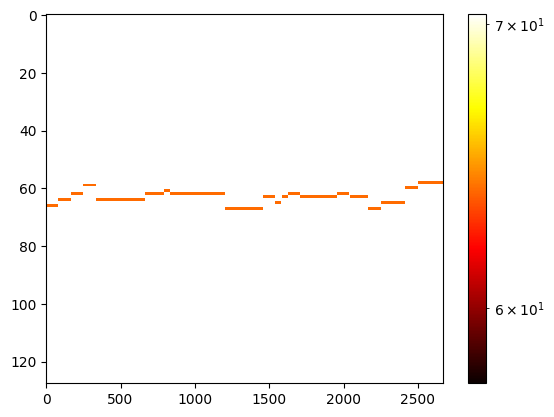

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.imshow(pianoroll[:, :], cmap='hot', interpolation='nearest', aspect='auto', norm=colors.LogNorm())
plt.colorbar()
plt.show()

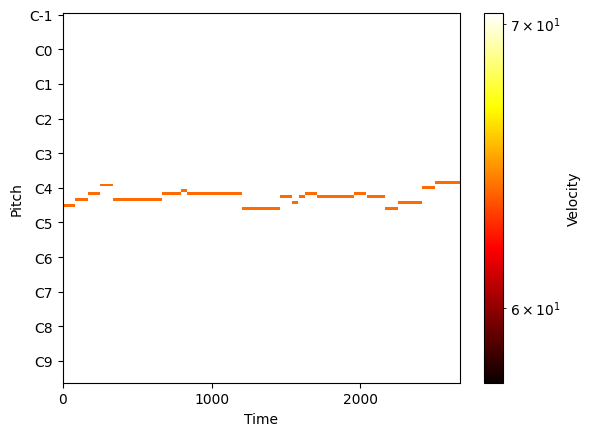

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Assuming 'pianoroll' is your piano roll matrix
# where rows correspond to pitches and columns to time steps

# Create the plot
plt.imshow(pianoroll, cmap='hot', interpolation='nearest', aspect='auto', norm=colors.LogNorm())
plt.colorbar(label='Velocity')

# Set the labels for the axes
plt.xlabel('Time')
plt.ylabel('Pitch')

# MIDI pitches range from 0 to 127. Mapping these to actual note names.
note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
pitch_labels = [f'{note_names[p % 12]}{p // 12 - 1}' for p in range(0, 128)]

# Set pitch labels every 12 steps (one octave)
plt.yticks(range(0, 128, 12), pitch_labels[::12])

# Time labels: Adjust the range and step as per your data's time resolution
time_labels = range(0, pianoroll.shape[1], 1000)  # Example: Mark every 10th time step
plt.xticks(time_labels, [f'{t}' for t in time_labels])

plt.show()
